### Copyright 2022 Edward Späth, Frankfurt University of Applied Sciences, FB2, Computer Science
### No liability or warranty; only for educational and non-commercial purposes
### See some basic hints for working with Jupyter notebooks in README.md

## Binary Search Tree data structure

## Global variables for storing information

In [1]:
DISPLAY_STEP_BY_STEP = False
states = []
comparisons = []
max_index = None
tree = []

## Output colors

In [2]:
# Node color. Defaults are 'black', 'white'
COL_NODE = 'black'
COL_FC_NODE = 'white'
# Nil node color. Defaults are 'white', 'black'
COL_NIL = 'white'
COL_FC_NIL = 'black'
# Edge color. Default is 'black'
COL_EDGE = 'black'
# Colors for highlighting successful and unsuccessful searches. Defaults are 'seagreen', 'tomato'
COL_SUCCESSFUL_SEARCH = 'seagreen'
COL_UNSUCCESSFUL_SEARCH = 'tomato'
# Colors for highlighting occupied nodes while trying to insert (DISPLAY_STEP_BY_STEP only). Defaults are 'salmon', 'white'
COL_OCCUPIED_NODE = 'salmon'
COL_FC_OCCUPIED_NODE = 'white'
# Colors for highlighting the node inserted node (DISPLAY_STEP_BY_STEP only). Defaults are 'seagreen', 'white'
COL_INSERT_NODE = 'seagreen'
COL_FC_INSERT_NODE = 'white'
# Unicode values for arrows printed on occupied nodes while trying to insert (DISPLAY_STEP_BY_STEP only). Defaults are '21a2', '21a3'
# How to change: Search for the unicode character you want and find its hexadecimal encoding.
# The left facing arrow with tail has the unidoe value U+21a2. Only the four hexadecimal digits are important. Just replace those below with those of your choice while leaving the \u intact
LEFT_FACING_ARROW = '\u21a2' # unicode for arrow with tail facing to the left
RIGHT_FACING_ARROW = '\u21a3' # unicode for arrow with tail facing to the right
# Edge thickness for colored edges going from occupied nodes to the next place to be inspected (DISPLAY_STEP_BY_STEP only). Defaults are '1', '3' (yes, the quotation marks are necessary!)
REGULAR_PENDWITH = '1'
THICK_PENDWITH = '3'

# Ignore below!
# Set "visibility" of invisible nodes
# 'dotted' for seing invisible nodes (debugging), 'invis' for hiding them
#INVISIBLE_NODE_STYLE = 'dotted'
INVISIBLE_NODE_STYLE = 'invis'

## Helper functions for easier access to children/parents of a given element in tree (heap)

In [3]:
def parent(i):
    if i <= 0: # In case parent(0) is called, instead of returning -1, it is safer to return None instead, since -1 is a valid index in python
        return None
    else:
        return (i-1)//2 # '//' means division with floor function (round down)

def left(i):
    return 2*i+1

def right(i):
    return 2*i+2

## Tree visualization

In [4]:
from graphviz import Graph
def draw_tree(local_tree, current_step=None):
    dot = Graph()
    dot.attr('graph', center='True')
    # Add nodes
    for index, node in enumerate(local_tree):
        direction_info = '' # Leave it blank and only change if necessary  below
        # Node to be inserted is compared to this node and is smaller
        if current_step != None and index == comparisons[current_step][0] and comparisons[current_step][1] == 'LEFT':
            dot.attr('node', style='filled', fillcolor=COL_OCCUPIED_NODE, fontcolor=COL_FC_OCCUPIED_NODE, fixedsize='True')
            direction_info = '\n' + LEFT_FACING_ARROW # Add arrow to label
         # Node to be inserted is compared to this node and is bigger or equal
        elif current_step != None and index == comparisons[current_step][0] and comparisons[current_step][1] == 'RIGHT':
            dot.attr('node', style='filled', fillcolor=COL_OCCUPIED_NODE, fontcolor=COL_FC_OCCUPIED_NODE, fixedsize='True')
            direction_info = '\n' + RIGHT_FACING_ARROW # Add arrow to label
        # Node is inserted
        elif current_step != None and index == comparisons[current_step][0] and comparisons[current_step][1] == 'INSERT':
            dot.attr('node', style='filled', fillcolor=COL_INSERT_NODE, fontcolor=COL_FC_INSERT_NODE, fixedsize='True')
        # For nodes with numbers
        elif node != 'EMP' and node != 'NIL':
            dot.attr('node', style='filled', fillcolor=COL_NODE, fontcolor=COL_FC_NODE, fixedsize='True')
        # For NIL nodes
        elif local_tree[parent(index)] != 'EMP' and local_tree[parent(index)] != 'NIL':
            dot.attr('node', style='filled', fillcolor=COL_NIL, fontcolor=COL_FC_NIL, fixedsize='True')
            local_tree[index] = 'NIL'
        # For invisible nodes
        else:
            dot.attr('node', style=INVISIBLE_NODE_STYLE, fixedsize='True')
        dot.node(str(index), str(local_tree[index]) + direction_info, ordering='out') # direction_info is either empty or an arrow showing the direction where the element is supposed to go
        # Calculate where invisible nodes belong
        if left(index) <= max_index or right(index) <= max_index:
            dot.attr('node', style=INVISIBLE_NODE_STYLE, fixedsize='True')
            dot.node('invis' + str(index), '___', ordering='out')
    # Add edges
    for index, node in enumerate(local_tree):
        # Edge between node and left child
        if left(index) <= max_index:
            if current_step != None and index == comparisons[current_step][0] and comparisons[current_step][1] == 'LEFT':
                 dot.attr('edge', style="filled", color=COL_OCCUPIED_NODE, penwidth=THICK_PENDWITH)
            elif node == 'EMP' or node == 'NIL':
                dot.attr('edge', style=INVISIBLE_NODE_STYLE, penwidth=REGULAR_PENDWITH)
            else:
                dot.attr('edge', style="filled", color=COL_EDGE, penwidth=REGULAR_PENDWITH)
            dot.edge(str(index), str(left(index)), weight='0')
        # Edge between node and middle node (invisible)
        if left(index) <= max_index or right(index) <= max_index:
            dot.attr('edge', style=INVISIBLE_NODE_STYLE, penwidth=REGULAR_PENDWITH)
            dot.edge(str(index), 'invis' + str(index), weight='1000')
        # Edge between node and right child
        if right(index) <= max_index:
            if current_step != None and index == comparisons[current_step][0] and comparisons[current_step][1] == 'RIGHT':
                 dot.attr('edge', style="filled", color=COL_OCCUPIED_NODE, penwidth=THICK_PENDWITH)
            elif node == 'EMP' or node == 'NIL':
                dot.attr('edge', style=INVISIBLE_NODE_STYLE, penwidth=REGULAR_PENDWITH)
            else:
                dot.attr('edge', style="filled", color=COL_EDGE, penwidth=REGULAR_PENDWITH)
            dot.edge(str(index), str(right(index)), weight='0')
    # Decide on the image label
    if current_step != None and current_step == len(states)-1:
        dot.attr(labelloc='t', label="Binary Search Tree result")
    elif current_step != None:
        dot.attr(labelloc='t', label="Binary Search Tree (Step " + str(current_step+1) + ')' + '\ninserting ' + str(comparisons[current_step][2]))
    else:
        dot.attr(labelloc='t', label="Binary Search Tree")
    display(dot)

## Constants for statistical output

In [5]:
X_FIGSIZE_SCALING_FACTOR = 1.5
X_MIN_FIGSIZE = 11
BOTTOM_TEXT_Y_CORD = 0.25 # y coordinate of the bottom text row
X_INFO_START = 1 # x coordinate where the first column of information starts (excluding column with labels such as name, predecessor, etc.)
Y_OFFSET_VLINE_HEIGHT = 0.15 # How many coordinate units the vertical lines are allowed to be higher/lower than the top/bottom text row
OFFSET = 0.5
COL_LINES = 'k'
REGULAR_LINE_WIDTH = 2
THICK_LINE_WIDTH = 4

## Outputting statistics

In [6]:
import matplotlib.pyplot as plt
def show_statistics(value_ranges, tree_search_details):
    x_figsize =(len(value_ranges)+2)*X_FIGSIZE_SCALING_FACTOR
    if x_figsize < X_MIN_FIGSIZE:
        x_figsize = X_MIN_FIGSIZE
    plt.figure(figsize=(x_figsize, 6)) 
    amt_information_rows = 3
    amt_h_lines = amt_information_rows-1
    y_end = amt_information_rows*OFFSET # The coordinate where the y axis ends
    x_end = (len(value_ranges)+1+2)*OFFSET+OFFSET/2 # The coordinate where the x axis ends
    plt.axis([0, x_end, 0, y_end]) # x_start, x_end, y_start, y_end
    plt.axis('off')
    # Plotting the regular hlines
    for j in range(0, amt_h_lines-1):
        plt.hlines(xmin=0, xmax=x_end, y=BOTTOM_TEXT_Y_CORD+OFFSET/2 + j*OFFSET, color=COL_LINES, linewidth=REGULAR_LINE_WIDTH)
    # Plotting the hline at the top 
    plt.hlines(xmin=-5, xmax=x_end, y=BOTTOM_TEXT_Y_CORD+OFFSET/2 + (amt_h_lines-1)*OFFSET, color=COL_LINES, linewidth=THICK_LINE_WIDTH)
    # Add the informational labels to the left
    info_y_cords = []
    information_labels = ['Key(s)', 'Key(s) found?', 'Amount Key\n comparisons']
    for j in range(0, amt_information_rows):
        info_y_cords.append(BOTTOM_TEXT_Y_CORD + j*OFFSET)
        plt.text(x=0, y=BOTTOM_TEXT_Y_CORD + j*OFFSET, s=information_labels[amt_information_rows-j-1], fontsize=16, verticalalignment='center', horizontalalignment='left')
    # Plot statistics (range of numbers searched, key found?, #key comparisons)
    for j in range(0, len(value_ranges)):
        x_cord = X_INFO_START + j*OFFSET
        if isinstance(value_ranges[j], tuple):
            # If the first element is a string, it is either 'Below' or 'Above'
            if isinstance(value_ranges[j][0], str):
                name_text_input = str(value_ranges[j][0]) + ' ' + str(value_ranges[j][1])
            else:
                # Layout: Two numbers with length/amount of digits < 3 --> 12 & 34, Left number with length < 3 and right number with length >= 3 --> 12 & \n 345, Both numbers with length >= 3 --> 123 \n & \n 456
                if len(str(value_ranges[j][0])) >= 3: 
                    left_value_space = '\n'
                else:
                    left_value_space = ' '
                if len(str(value_ranges[j][1])) >= 3:
                    right_value_space = '\n'
                else:
                    right_value_space = ' '
                name_text_input = 'Between\n' + str(value_ranges[j][0]) + left_value_space + '&' + right_value_space + str(value_ranges[j][1])
        else:
            name_text_input = str(value_ranges[j])
        plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-1)*OFFSET, s=name_text_input, fontsize=16, verticalalignment='center', horizontalalignment='center')
        if tree_search_details[j][0] == True:
            plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-2)*OFFSET, s=str(tree_search_details[j][0]), fontsize=16, verticalalignment='center', horizontalalignment='center',
                     bbox=dict(facecolor=COL_SUCCESSFUL_SEARCH, edgecolor=COL_SUCCESSFUL_SEARCH, pad=5.0, fill=True, alpha=0.4))
        else:
            plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-2)*OFFSET, s=str(tree_search_details[j][0]), fontsize=16, verticalalignment='center', horizontalalignment='center',
                     bbox=dict(facecolor=COL_UNSUCCESSFUL_SEARCH, edgecolor=COL_UNSUCCESSFUL_SEARCH, pad=5.0, fill=True, alpha=0.4))
        plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-3)*OFFSET, s=str(tree_search_details[j][1]), fontsize=16, verticalalignment='center', horizontalalignment='center')
    # Calculating the average search time for successful searches
    average_successful = 0
    amt_successful_searches = 0
    for i in range(0, len(tree_search_details)):
        if tree_search_details[i][0] == True:
            average_successful += tree_search_details[i][1]
            amt_successful_searches += 1
    average_successful /= amt_successful_searches
    average_successful = round(average_successful, 2)
    # Calculating the average search time for unsuccessful searches
    average_unsuccessful = 0
    amt_unsuccessful_searches = 0
    for i in range(0, len(tree_search_details)):
        if tree_search_details[i][0] == False:
            average_unsuccessful += tree_search_details[i][1]
            amt_unsuccessful_searches += 1
    average_unsuccessful /= amt_unsuccessful_searches 
    average_unsuccessful = round(average_unsuccessful, 2)
    # Plot average search times   
    x_cord = X_INFO_START + len(value_ranges)*OFFSET
    plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-1)*OFFSET, s='Average', fontsize=16, verticalalignment='center', horizontalalignment='center')
    plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-2)*OFFSET, s=str(True), fontsize=16, verticalalignment='center', horizontalalignment='center',
                     bbox=dict(facecolor='seagreen', edgecolor='seagreen', pad=5.0, fill=True, alpha=0.4))
    plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-3)*OFFSET, s=str(average_successful), fontsize=16, verticalalignment='center', horizontalalignment='center')
    
    x_cord = X_INFO_START + (len(value_ranges)+1)*OFFSET
    plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-1)*OFFSET, s='Average', fontsize=16, verticalalignment='center', horizontalalignment='center')
    plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-2)*OFFSET, s=str(False), fontsize=16, verticalalignment='center', horizontalalignment='center',
                     bbox=dict(facecolor='tomato', edgecolor='tomato', pad=5.0, fill=True, alpha=0.4))
    plt.text(x=x_cord, y=BOTTOM_TEXT_Y_CORD + (amt_information_rows-3)*OFFSET, s=str(average_unsuccessful), fontsize=16, verticalalignment='center', horizontalalignment='center')
    
    plt.vlines(x=X_INFO_START-OFFSET/2 + len(value_ranges)*OFFSET, ymin=BOTTOM_TEXT_Y_CORD-Y_OFFSET_VLINE_HEIGHT, 
                   ymax=BOTTOM_TEXT_Y_CORD + (amt_information_rows-1)*OFFSET + Y_OFFSET_VLINE_HEIGHT, color=COL_LINES, linewidth=THICK_LINE_WIDTH)
    # Add a vertical line seperating the averages from the rest
    for vline_index in range(0, len(value_ranges)+2):
        plt.vlines(x=X_INFO_START-OFFSET/2 + vline_index*OFFSET, ymin=BOTTOM_TEXT_Y_CORD-Y_OFFSET_VLINE_HEIGHT, 
                   ymax=BOTTOM_TEXT_Y_CORD + (amt_information_rows-1)*OFFSET + Y_OFFSET_VLINE_HEIGHT, color=COL_LINES, linewidth=REGULAR_LINE_WIDTH)
    labelinput = "Statistics regarding key comparisons for finding elements in tree"
    plt.title(labelinput , fontsize=20)
    plt.show()

## Adjust input and call algorithm

In [7]:
import copy
def save_state(index, direction, value):
    global states, comparisons
    states.append(copy.deepcopy(tree))
    comparisons.append((index, direction, value))

In [8]:
def insertion_algorithm(user_input):
    global states, tree
    # EMP stands for empty, I chose EMP over EMPTY as the label because EMP has 3 letters just like NIL.
    # That way the strings are of the same size and fit better into the node
    tree_list_max_size = 2 ** len(user_input)
    tree = ['EMP'] * tree_list_max_size
    for value in user_input:
        y = 'NIL'
        x = 0
        while tree[x] != 'EMP':
            y = x
            if value < tree[x]:
                x = left(x)
                save_state(parent(x), 'LEFT', value) 
            else:
                x = right(x)
                save_state(parent(x), 'RIGHT', value) 
        if y == 'NIL':
            tree[0] = value
            save_state(0, 'INSERT', value)
        elif value < tree[y]:
            tree[left(y)] = value
            save_state(left(y), 'INSERT', value)
        else:
            tree[right(y)] = value
            save_state(right(y), 'INSERT', value)
    save_state('NONE', 'NONE', 'NONE')

In [9]:
def tree_search(local_tree, index, target):
    key_comparisons = 0
    while local_tree[index] != 'NIL' and local_tree[index] != 'EMP' and target != local_tree[index]:
        if target < local_tree[index]:
            index = left(index)
        else:
            index = right(index)
        key_comparisons += 1
    if local_tree[index] == 'NIL' or local_tree[index] == 'EMP':
        return False, key_comparisons
    else:
        return True, key_comparisons+1 # +1 since the final key comparison is in while condition: "target != tree[index]"

In [10]:
import math
def balance_tree():
    global max_index, tree
    # Remove empty list slots up until the last number
    for i in reversed(range(0, len(tree))):
        if tree[i] == 'EMP':
            del tree[i]
            for state_index in range(0, len(states)):
                del states[state_index][i]
        else:
            break
    # Add empty slots until the last level is full
    while math.log2(len(tree)+1) != math.floor(math.log2(len(tree)+1)):
        tree.append('EMP')
        for state_index in range(0, len(states)):
            states[state_index].append('EMP')
    # Add empty slots to create an entirely new level (for NIL nodes)
    tree.append('EMP')
    for state_index in range(0, len(states)):
            states[state_index].append('EMP')
    while math.log2(len(tree)+1) != math.floor(math.log2(len(tree)+1)):
        tree.append('EMP')
        for state_index in range(0, len(states)):
            states[state_index].append('EMP')
    # Save the last available index
    max_index = len(tree)-1
    # This is the maximum amount of nodes that can be displayed in the worst case scenario 
    # In this case you would have 63 nodes with just 5 values being inserted if it were to be a degenerated tree (6 since NIL node after the 5th also counts)
    # This grows exponentially. Having it be 6 instead of 5 would lead to 127 nodes being present, which is neither readable nor manageable for graphviz. It just returns a black image if prompted to.
    # Trees are limited to having a maximum height of 5. The error_message makes sure to not render the graph if the maximum were to be surpassed
    if len(tree) > 63:
        error_message = 'DO_NOT_DRAW'
    else:
        error_message = ''
    return error_message

In [11]:
def calculate_statistics(user_input):
    user_input.sort()
    value_ranges = []
    tree_search_details = []
    for j in range(0, len(user_input)-1):
        value_ranges.append(user_input[j])
        value_ranges.append((user_input[j], user_input[j+1]))
    value_ranges.append(user_input[-1])
    for value_range in value_ranges:
        if isinstance(value_range, tuple):
            target = (value_range[0] + value_range[1]) / 2
        else:
            target = value_range
        key_found, key_comparisons = tree_search(states[-1], 0, target)
        tree_search_details.append((key_found, key_comparisons))
    # For values below lowest number
    value_ranges.insert(0, 'Below\n'+str(user_input[0]))
    key_found, key_comparisons = tree_search(states[-1], 0, user_input[0]-1)
    tree_search_details.insert(0, (key_found, key_comparisons))
    # For values above highest number
    value_ranges.append('Above\n'+str(user_input[-1]))
    key_found, key_comparisons = tree_search(states[-1], 0, user_input[-1]+1)
    tree_search_details.append((key_found, key_comparisons))
    return value_ranges, tree_search_details

In [12]:
import random
def generate_random_list(amount_of_values):
    values_0_to_99 = list(range(0, 100))
    used_values = []
    random_list = []
    for j in range(amount_of_values):
        available_options = list(set(values_0_to_99) - set(used_values))
        random_value = random.choice(available_options)
        used_values.append(random_value)
        random_list.append(random_value)
    return random_list

In [13]:
def show_output(input_values):
    global states, comparisons
    # Insert values into tree
    insertion_algorithm(input_values)
    # Balance tree and add a new level for NIL nodes
    error_message = balance_tree()
    # Only display tree if there will be no problem visualizing it (see balance_tree()-function for details)
    if error_message != 'DO_NOT_DRAW':
        # Display tree either step by step or in just one image
        if DISPLAY_STEP_BY_STEP:
            for i in range(0, len(states)):
                draw_tree(states[i], i)
        else:
            draw_tree(tree)
    else:
        print(" Tree cannot be displayed as it is too big (trees are allowed to have a maximum height of 5 elements)\n", 
              "This means that degenerated trees (inserting in ascending or descending order have a maximum of 5 elements)\n",
              "The statistics of the tree can still be printed, but the graph visualization is not possible")
    # Calculate and show statistics
    value_ranges, key_comparisons_per_range = calculate_statistics(input_values)
    show_statistics (value_ranges, key_comparisons_per_range)
    # Reset states for next tree
    states = []
    comparisons = []

## Example with explanation

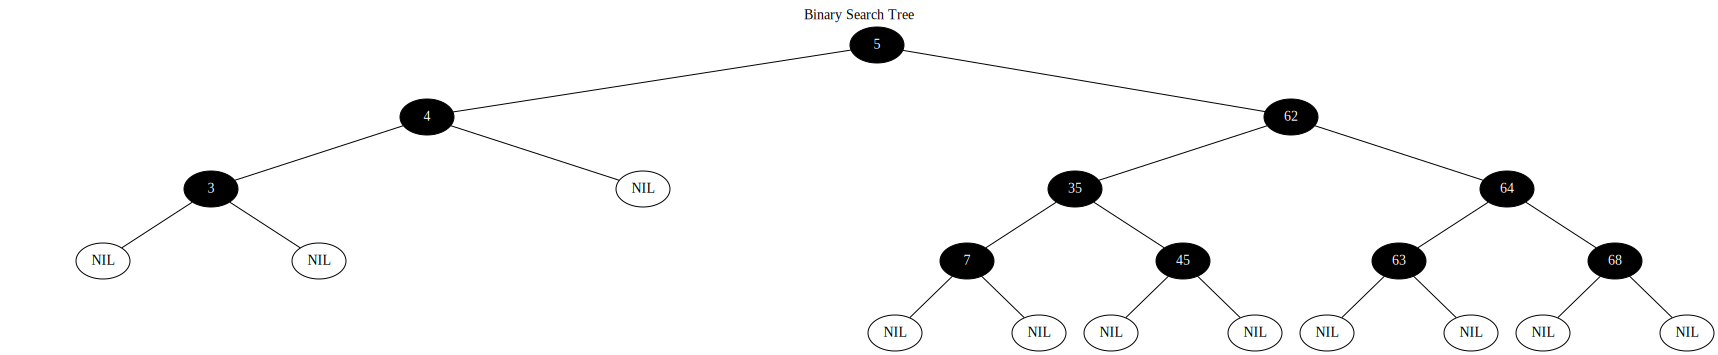

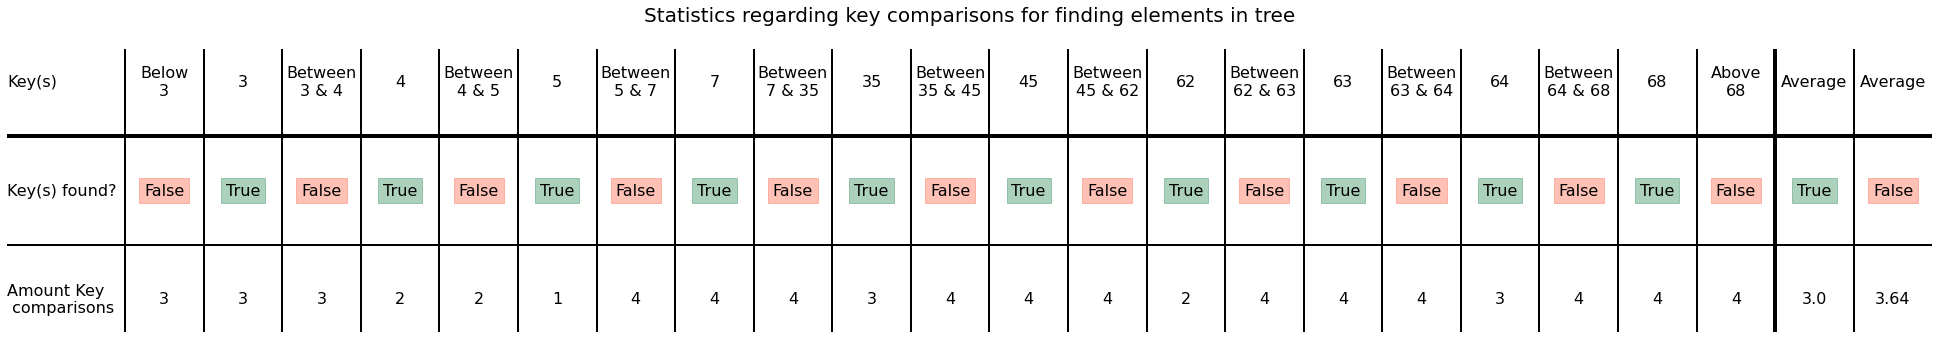

In [14]:
# Input the values you want to store in the binary search tree
input_values = [5, 62, 4, 35, 7, 45, 3, 64, 63, 68]

# Turn this from "False" to "True" if you want to see the insertions step by step
DISPLAY_STEP_BY_STEP = False
show_output(input_values)

## Yet another example

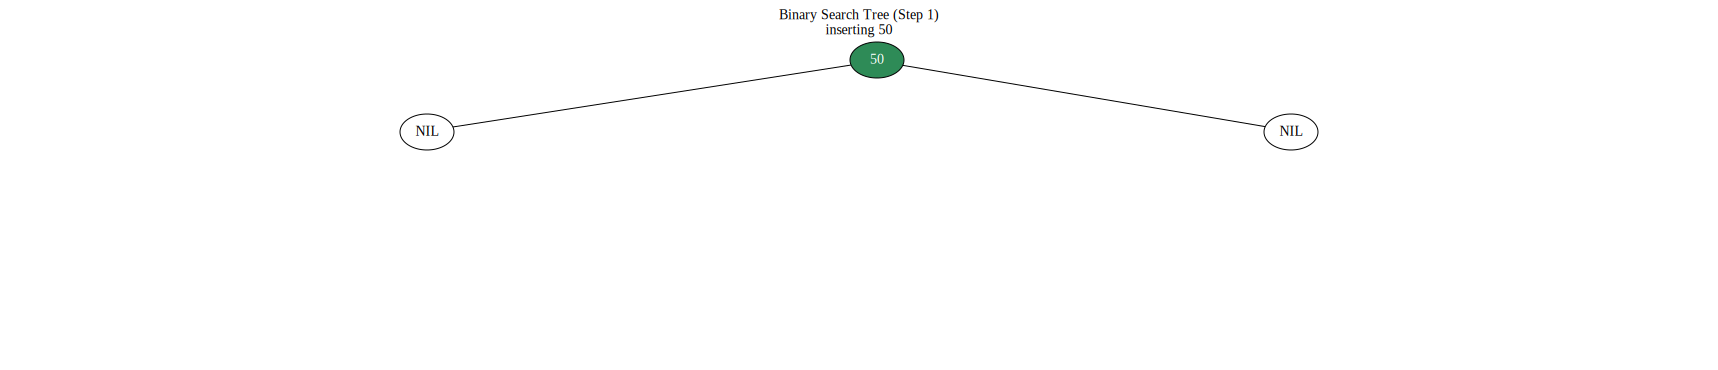

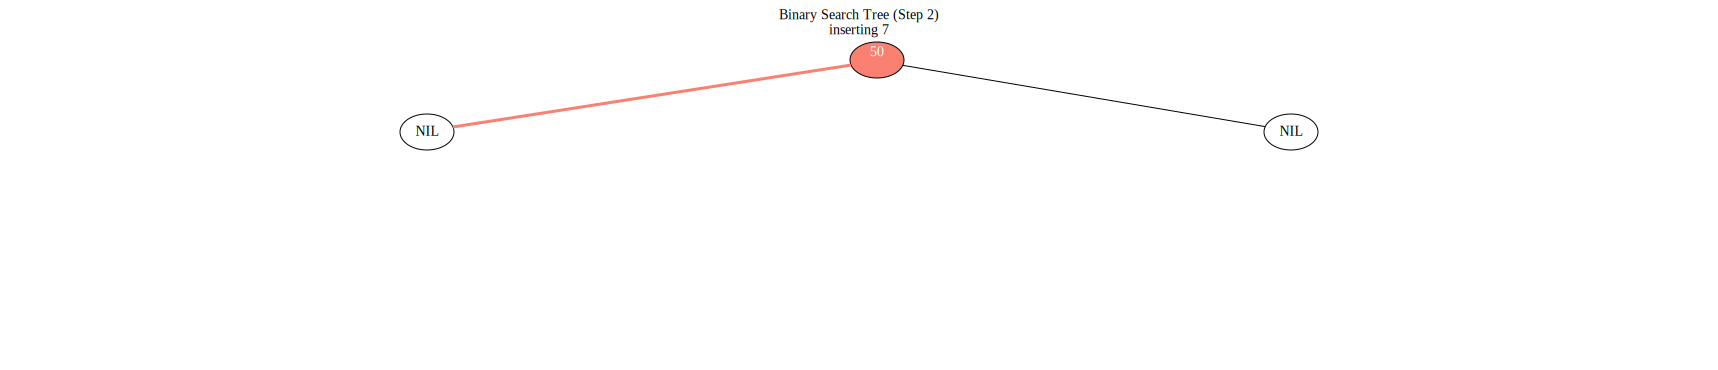

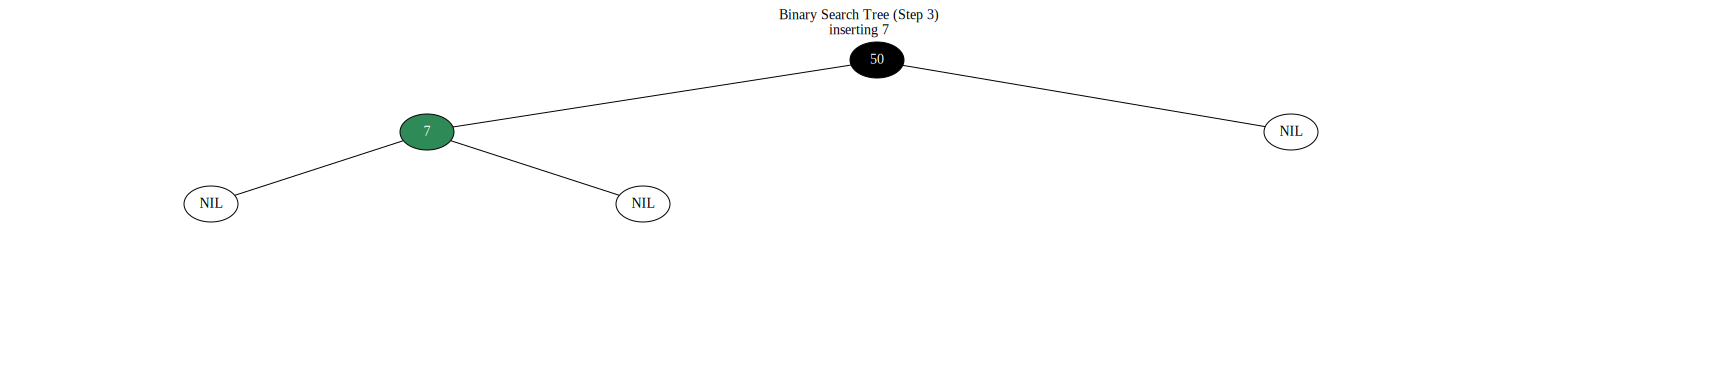

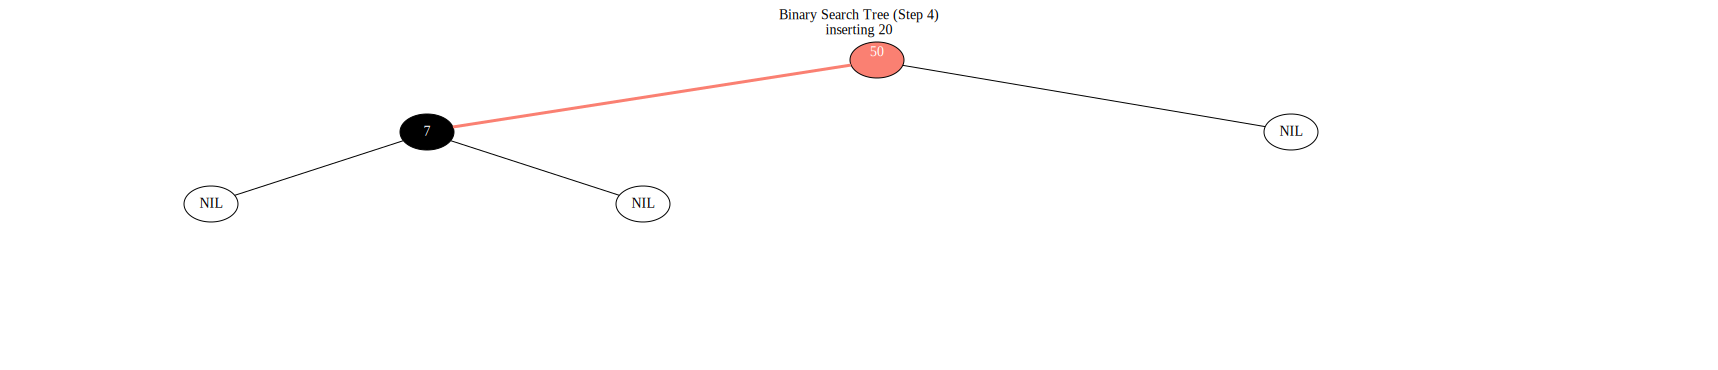

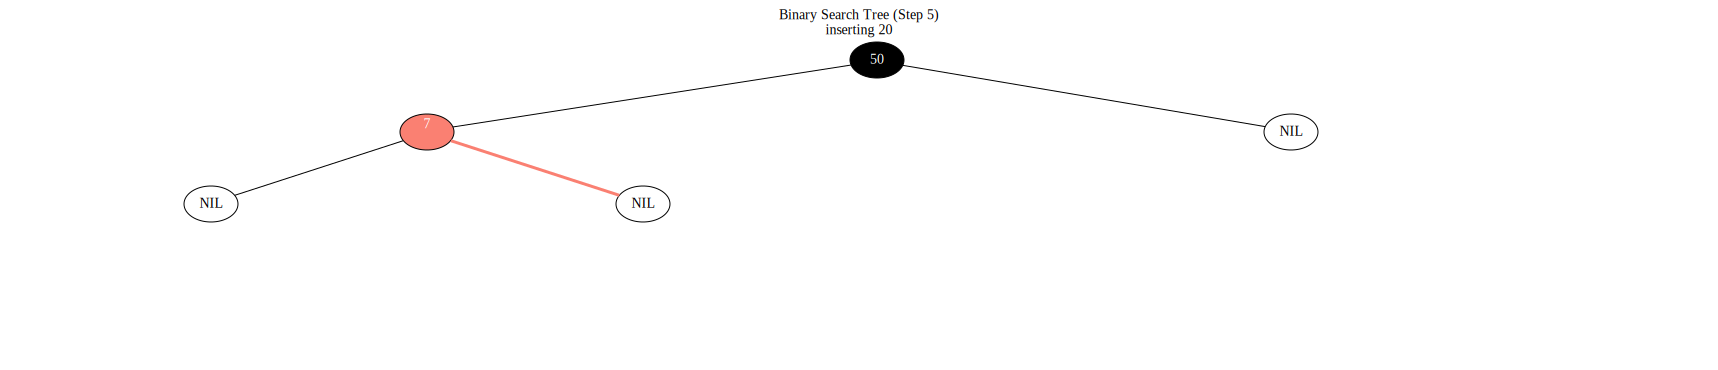

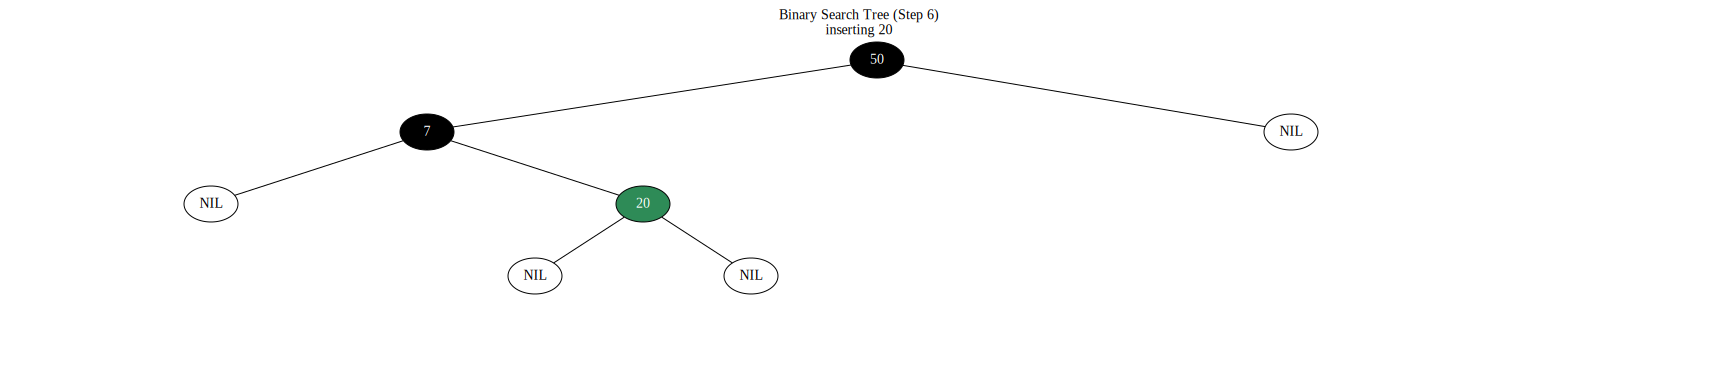

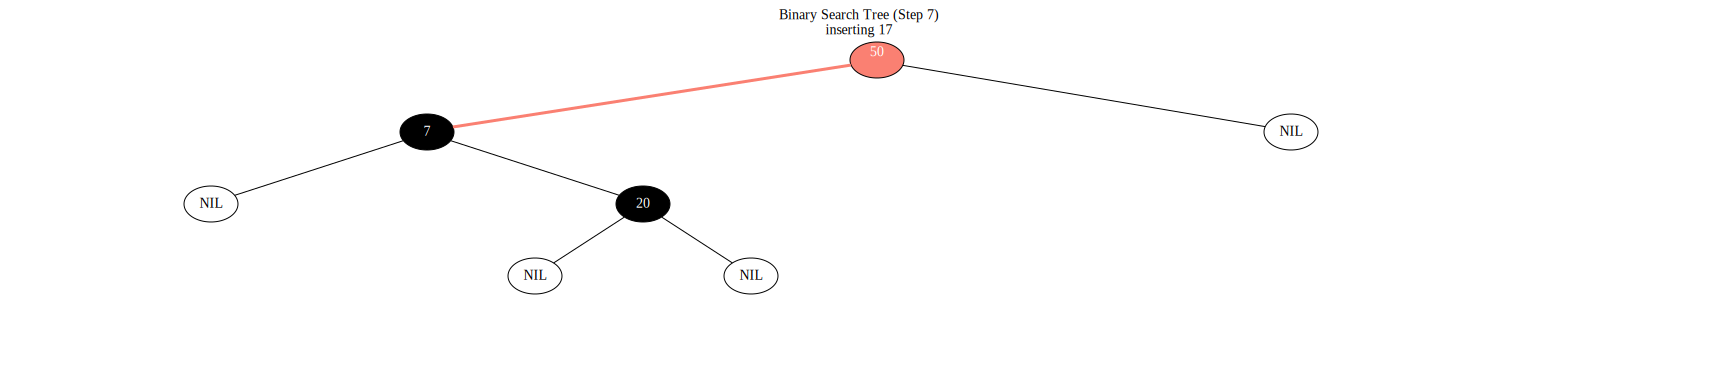

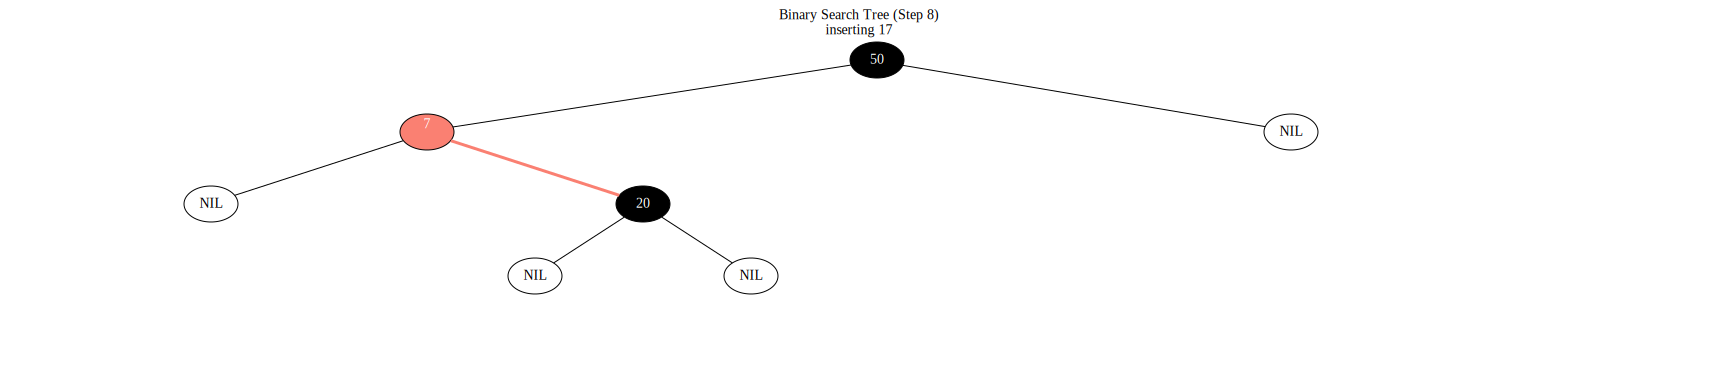

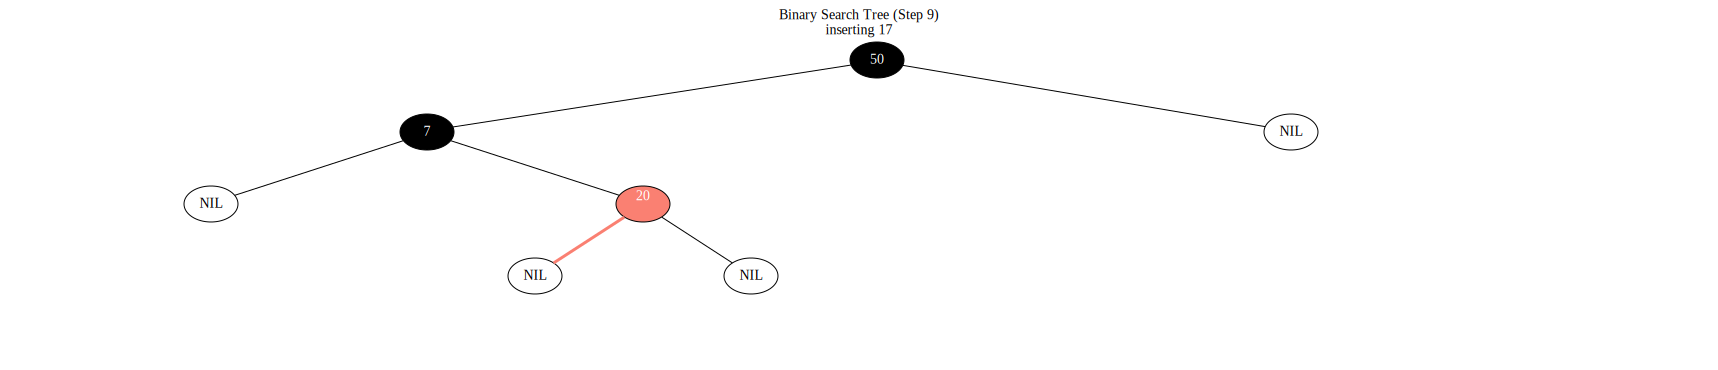

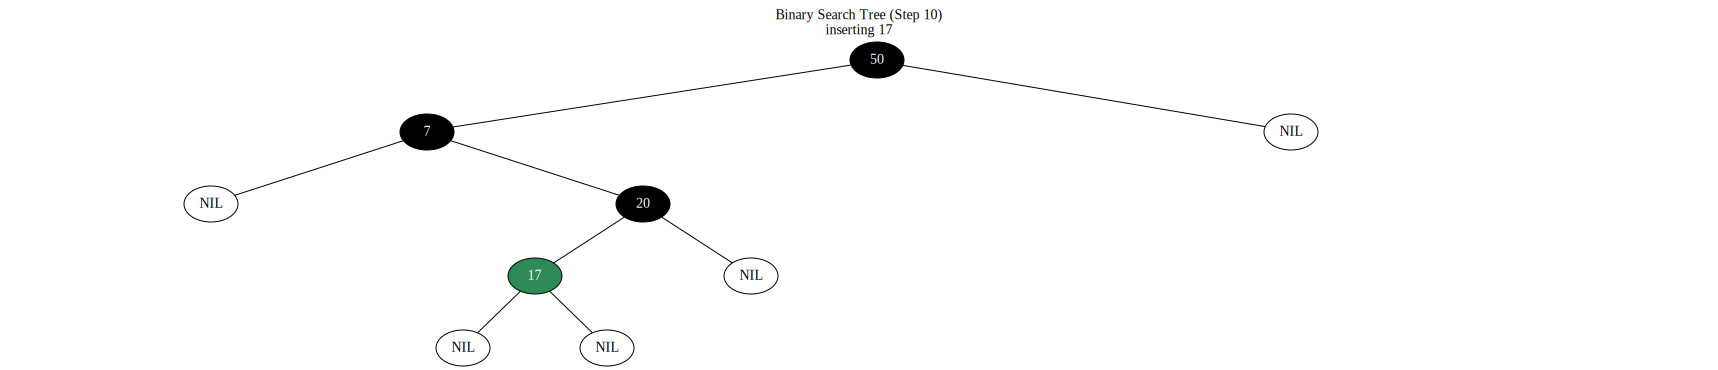

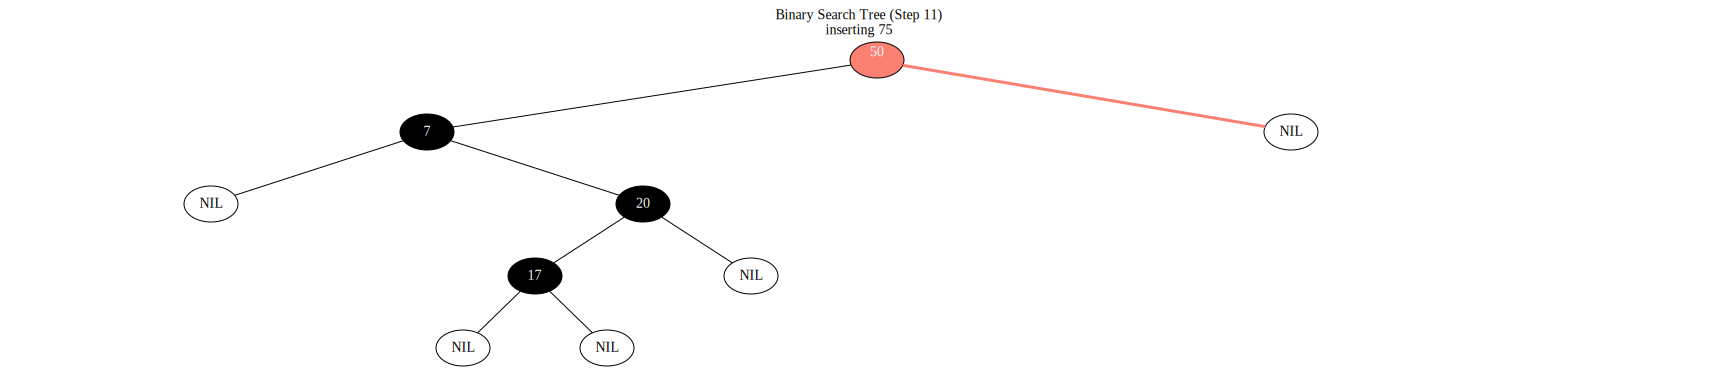

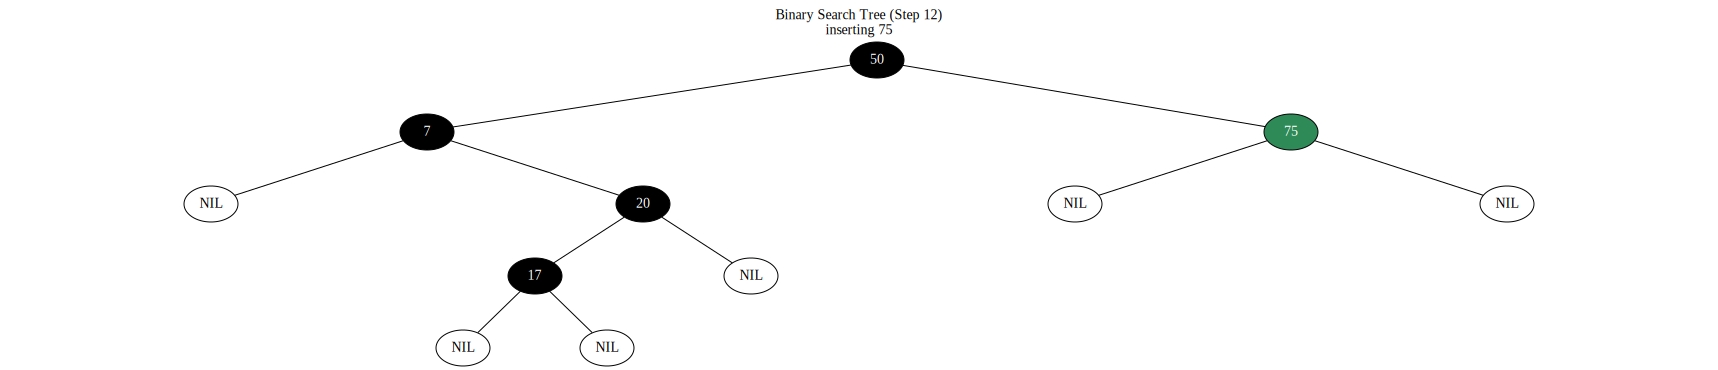

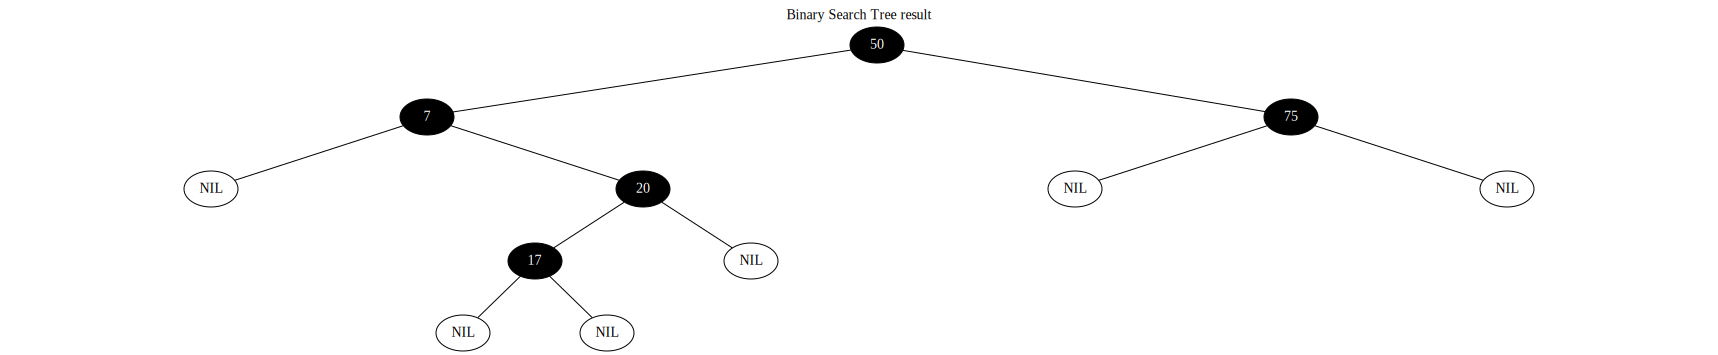

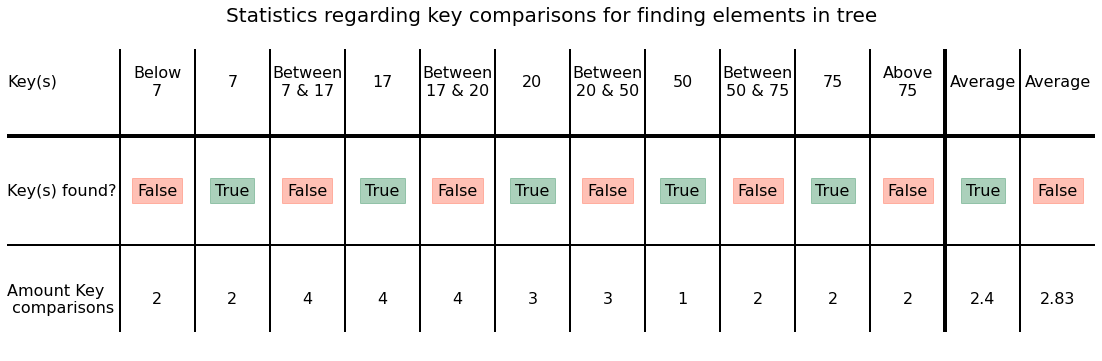

In [15]:
input_values = [50, 7, 20, 17, 75]

DISPLAY_STEP_BY_STEP = True
show_output(input_values)

## Randomly generated tree

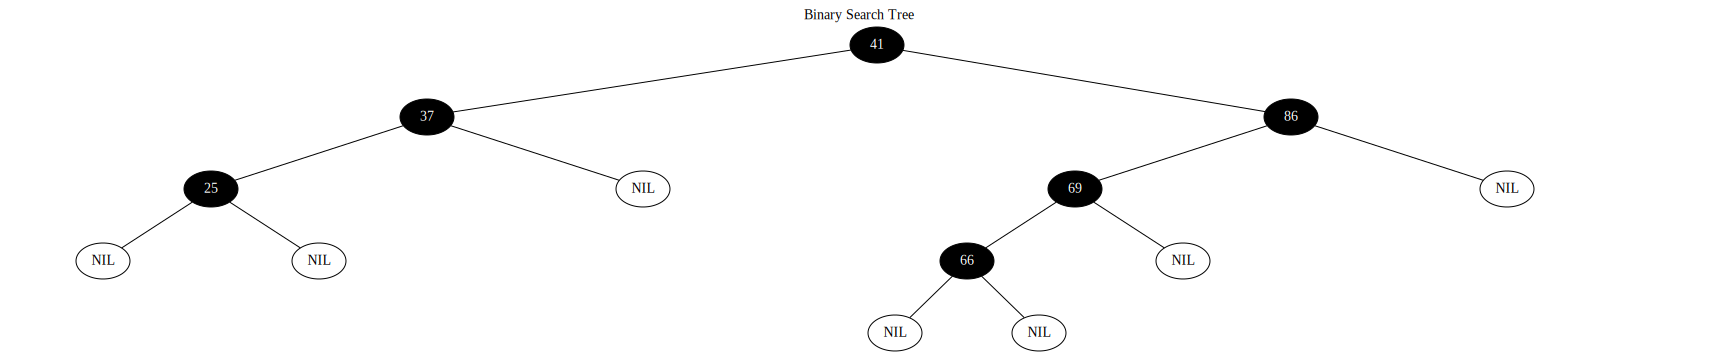

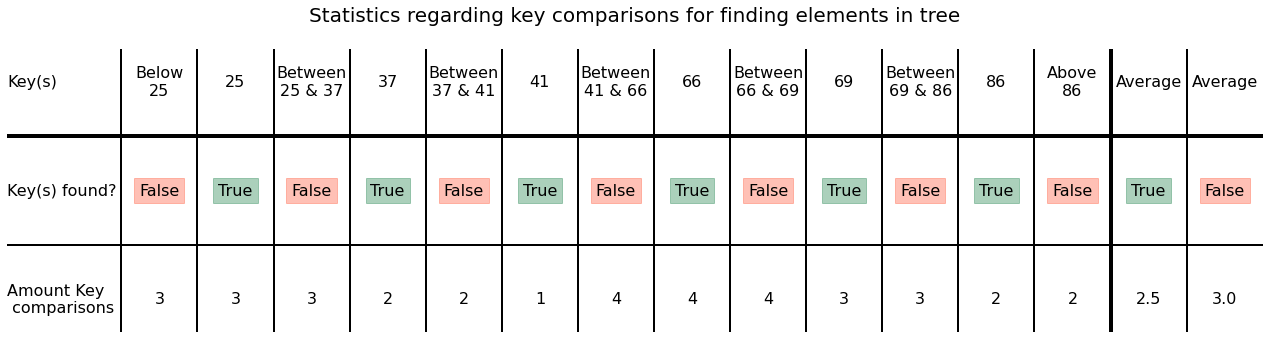

In [16]:
# Adjust how many values the randomly generated tree is supposed to have
amount_of_values = 6
random_input = generate_random_list(amount_of_values)

DISPLAY_STEP_BY_STEP = False
show_output(random_input)

## Your tests go here...

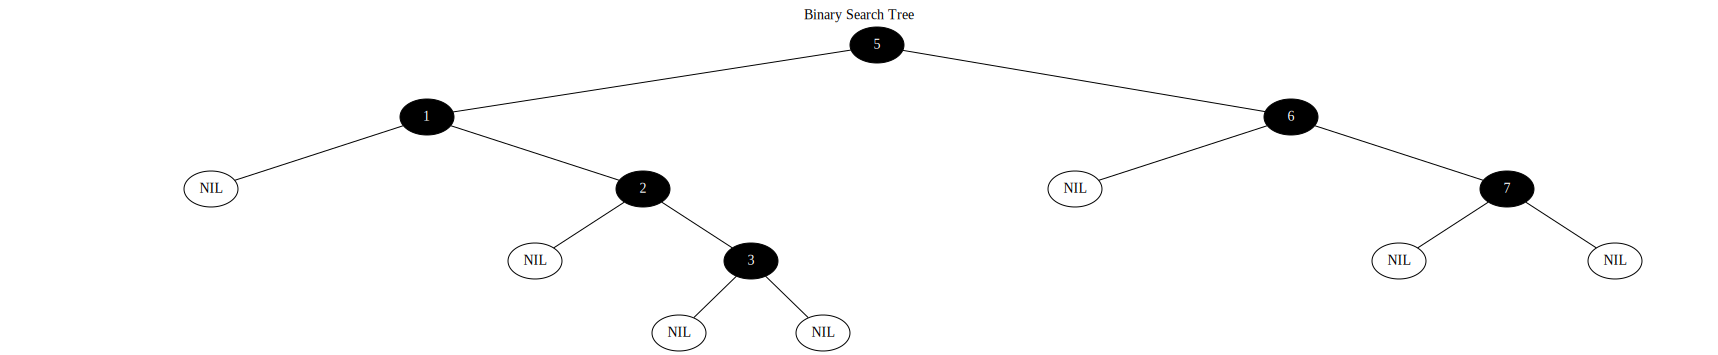

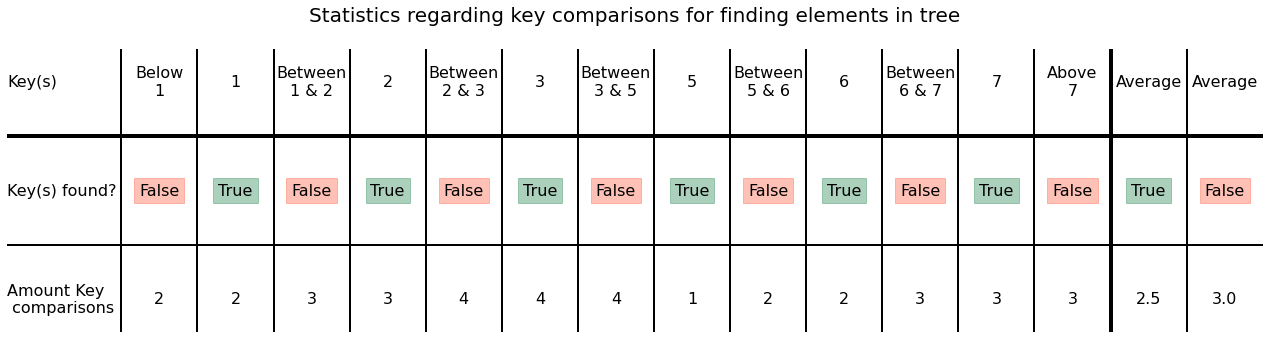

In [17]:
user_input = [5, 1, 2, 6, 7, 3]

DISPLAY_STEP_BY_STEP = False
show_output(user_input)